In [4]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot

# Setting up the Project

## Loading the Dataset

In [5]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


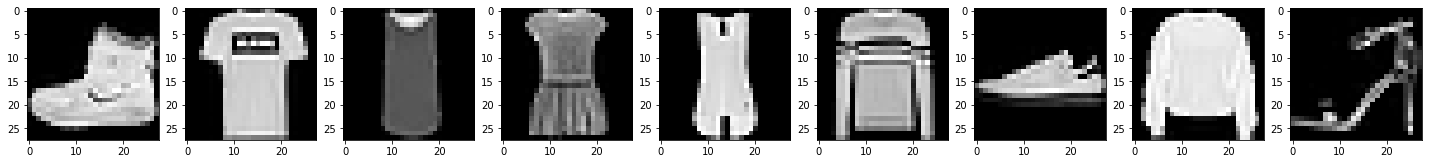

In [35]:
fig = pyplot.gcf()
fig.set_size_inches(25, 10.5)
fig.savefig('test2png.png', dpi=100)

for i in range(9):
	pyplot.subplot(1,9,i + 1)
	pyplot.imshow(x_train[i],cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()